In [76]:
import math
import itertools
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
print("Site-Dependent Multi-Trip Periodic Vehicle Routing Problem")
print("We have 10 input files")
files=["sdmtpvrp1.txt","sdmtpvrp2.txt","sdmtpvrp3.txt","sdmtpvrp4.txt","sdmtpvrp5.txt","sdmtpvrp6.txt","sdmtpvrp7.txt","sdmtpvrp8.txt","sdmtpvrp9.txt","sdmtpvrp10.txt"]
print("Choosing the first file to work upon")
file=0 #change the value of this file variable(0-9) to change the file of your choice

Site-Dependent Multi-Trip Periodic Vehicle Routing Problem
We have 10 input files
Choosing the first file to work upon


In [6]:
with open(files[0], 'r') as f:

    # read the first line of the file
    n, t, C, P, m, tt = map(float, f.readline().split())

    # read the depot information
    depot_x, depot_y, lt = map(float, f.readline().split())

    # create a list to store the vehicle information
    vehicles = []

    # read the information for each vehicle
    for i in range(int(m)):
        p, Q, D, c = map(int, f.readline().split())
        vehicles.append((p, Q, D, c))

    # create a list to store the customer information
    customers = []

    # read the information for each customer
    for i in range(int(n)):
        line =f.readline()
        line = line.strip().split()
        line_len=len(line)
        rem_len=line_len-6
        x = float(line[0])
        y = float(line[1])
        q = int(line[2])
        ut = int(line[3])
        freq = int(line[4])
        a = int(line[5])
        list1 = list(map(int, line[6:6+a]))
        e = int(line[7+a])
        list2 = list(map(int, line[7+a:]))
        customers.append((x, y, q, ut, freq, a, list1, e, list2))

    # create a list to store the delivery-day pattern information
    delivery_patterns = []

    #read the information for each delivery-day pattern
    for i in range(int(C)):
        line =f.readline()
        line = line.strip().split()
        freq = int(line[0])
        days = list(map(int, line[1:]))
        delivery_patterns.append((freq, days))


In [7]:
#function to print input data
def print_input():
    print("The input parameters are as follows:\n")
    print("GENERAL INFORMATION:\n")
    print("\tNumber of customers: ",int(n))
    print("\tNumber of days of the period: ",int(t))
    print("\tTotal number of delivery-day patterns: ",int(C))
    print("\tTotal number of vehicle types: ",int(P))
    print("\tNumber of vehicles: ",int(m))
    print("\tProportionality constant for travel time: ",int(tt))
    print()
    print("DEPOT INFORMATION\n")
    print("\tDepot Location on x-y axis: ",int(depot_x)," , ",int(depot_y))
    print("\tProportionality constant for load time: ",int(lt))
    print()
    print("VEHICLE INFORMATION\n")
    for i in range(int(m)):
        print("\tVehicle ",i+1,":")
        print("\t\tVehicle Type: ",int(vehicles[i][0]))
        print("\t\tMaximum Load: ",int(vehicles[i][1]))
        print("\t\tMaximum duration of a route: ",int(vehicles[i][2]))
        print("\t\tOperation cost per unit of distance travelled: ",int(vehicles[i][3]))
        print()
    print("CUSTOMER INFORMATION\n")
    for i in range(int(n)):
        print("\tCustomer ",i+1,":")
        print("\t\tCustomer Location: ",int(customers[i][0])," , ",int(customers[i][1]))
        print("\t\tDemand: ",int(customers[i][2]))
        print("\t\tProportionality constant for unload time: ",int(customers[i][3]))
        print("\t\tFrequency of a visit: ",int(customers[i][4]))
        print("\t\tNumber of possible visit combinations: ",int(customers[i][5]))
        print("\t\tList of all possible visit combinations: ",' , '.join(map(str,customers[i][6])))
        print("\t\tNumber of possible vehicle types: ",int(customers[i][7]))
        print("\t\tList of all possible vehicle types: ",' , '.join(map(str,customers[i][8])))
        print()
    print("EACH DEILVERY DAY PATTERN INFORMATION\n")
    for i in range(int(C)):
        print("\tPattern ",i+1,":")
        print("\t\tFrequency of visit: ",int(delivery_patterns[i][0]))
        print("\t\tList visit days: ",' , '.join(map(str,delivery_patterns[i][1])))
        print()

In [79]:
# Define distance function
def distance(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2) * tt

# Define load time function
def load_time(q):
    return q * depot_y

# Define unload time function
def unload_time(q):
    return q * ut

# Define cost function
def cost(distance, vehicle_type):
    return distance * vehicles[vehicle_type][3]

# Define state representation
# A state is represented as a tuple (remaining_customers, current_load, current_location, current_time, current_vehicle_type)
# where remaining_customers is a list of customer indices, current_load is the current load on the vehicle,
# current_location is a tuple (x, y) representing the current location of the vehicle,
# current_time is the current time, and current_vehicle_type is the index of the current vehicle type in the vehicles list.
# The state also includes the cost incurred so far.
def state(remaining_customers, current_load, current_location, current_time, current_vehicle_type, cost_so_far):
    return (remaining_customers, current_load, current_location, current_time, current_vehicle_type, cost_so_far)

# Define initial state
initial_state = state(list(range(int(n))), 0, (depot_x, depot_y), 0, 0, 0)
    

# Define goal test function
def is_goal(state):
    return not state[0] and state[1] == 0

In [8]:
print_input()

The input parameters are as follows:

GENERAL INFORMATION:

	Number of customers:  50
	Number of days of the period:  2
	Total number of delivery-day patterns:  3
	Total number of vehicle types:  2
	Number of vehicles:  2
	Proportionality constant for travel time:  1

DEPOT INFORMATION

	Depot Location on x-y axis:  19  ,  -15
	Proportionality constant for load time:  2

VEHICLE INFORMATION

	Vehicle  1 :
		Vehicle Type:  1
		Maximum Load:  100
		Maximum duration of a route:  1800
		Operation cost per unit of distance travelled:  1

	Vehicle  2 :
		Vehicle Type:  2
		Maximum Load:  150
		Maximum duration of a route:  1800
		Operation cost per unit of distance travelled:  2

CUSTOMER INFORMATION

	Customer  1 :
		Customer Location:  -22  ,  -16
		Demand:  3
		Proportionality constant for unload time:  2
		Frequency of a visit:  1
		Number of possible visit combinations:  2
		List of all possible visit combinations:  1 , 2
		Number of possible vehicle types:  1
		List of all possible veh

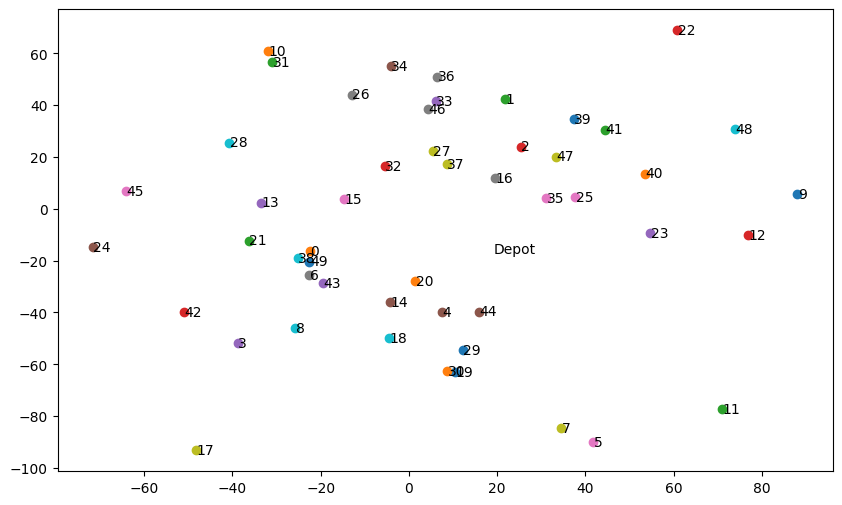

In [86]:
plt.figure(figsize=(10,6))
plt.plot(depot_x,depot_y)
plt.text(depot_x+.01,depot_y,"Depot",horizontalalignment='left',verticalalignment='center')
for s in range(len(customers)):
    p = customers[s]
    plt.plot(p[0],p[1],'o')
    plt.text(float(p[0])+0.1,p[1],s,horizontalalignment='left',verticalalignment='center')

In [87]:
position=pd.DataFrame(columns=["Customer","X","Y"])
for i in range(len(customers)):
    new_row = {'Customer':i, 'X':int(customers[i][0]), 'Y':int(customers[i][1])}
    position = pd.concat([position, pd.DataFrame([new_row])], ignore_index=True)

In [88]:
position.head()

Customer    X    Y
0        0  -22  -16
1        1   21   42
2        2   25   23
3        3  -38  -51
4        4    7  -39

In [89]:
x_coords = position['X'].values.astype(float)
y_coords = position['Y'].values.astype(float)

# Compute the distance matrix using the Euclidean distance formula
distance_matrix = np.sqrt((x_coords[:, np.newaxis] - x_coords)**2 + (y_coords[:, np.newaxis] - y_coords)**2)


In [90]:
distance_matrix_df = pd.DataFrame(distance_matrix)

In [149]:
travelTIme=df_new = distance_matrix_df.multiply(tt)

In [154]:
travelTIme.head()

0           1           2           3          4           5    
0   0.000000   86.641330   73.288471   46.180515  44.416213  116.622468  \
1  86.641330    0.000000   23.299785  132.163535  98.641168  160.207865   
2  73.288471   23.299785    0.000000  116.622468  77.472059  136.952547   
3  46.180515  132.163535  116.622468    0.000000  55.887029  105.722656   
4  44.416213   98.641168   77.472059   55.887029   0.000000   73.553246   

          6           7           8           9   ...          40          41   
0  10.800000  105.709035   36.179552  134.383928  ...   96.493730   96.538490  \
1  95.533868  152.002632  119.157039   91.845087  ...   51.822775   31.130692   
2  80.614639  128.853405  102.253802   78.625187  ...   35.678565   24.298148   
3  36.634410   95.042727   16.714066  165.460811  ...  133.502360  138.312689   
4  38.642981   62.974280   39.308014  110.615008  ...   83.311464   93.953180   

           42         43         44          45          46          47   
0   43.482410  14.843180  52.279250   56.895694   71.919956   78.881176  \
1  129.255097  96.747093  97.466302  110.771115   20.957099   30.071914   
2  116.770544  80.828708  75.361529  108.730860   30.968371   10.252804   
3   20.364675  35.799441  65.209815   75.179785  118.094877  120.490996   
4   68.400000  33.877426   9.600000  100.871403   92.470103   77.369762   

           48         49  
0  126.661123   4.800000  
1   64.039988  90.542366  
2   58.209278  76.442920  
3  164.894148  41.862633  
4  114.579579  41.603846  

[5 rows x 50 columns]

In [91]:
distances = dict( ((s1,s2), distance_matrix_df.loc[s1, s2] ) for s1 in range(len(position)) for s2 in range(len(position)) if s1!=s2)

In [92]:
distances

{(0, 1): 72.20110802473879,
 (0, 2): 61.07372593840988,
 (0, 3): 38.48376280978771,
 (0, 4): 37.013511046643494,
 (0, 5): 97.18538984847466,
 (0, 6): 9.0,
 (0, 7): 88.09086218218096,
 (0, 8): 30.14962686336267,
 (0, 9): 111.9866063420086,
 (0, 10): 76.53103945458993,
 (0, 11): 110.38568747804219,
 (0, 12): 98.18350166906862,
 (0, 13): 21.095023109728988,
 (0, 14): 26.1725046566048,
 (0, 15): 20.615528128088304,
 (0, 16): 49.09175083453431,
 (0, 17): 81.27115109311545,
 (0, 18): 37.589892258425,
 (0, 19): 56.859475903318,
 (0, 20): 25.495097567963924,
 (0, 21): 14.560219778561036,
 (0, 22): 117.38824472663352,
 (0, 23): 76.32168761236873,
 (0, 24): 49.040799340956916,
 (0, 25): 62.297672508690084,
 (0, 26): 60.8276253029822,
 (0, 27): 46.61544808322666,
 (0, 28): 44.77722635447622,
 (0, 29): 50.99019513592785,
 (0, 30): 54.91812087098393,
 (0, 31): 72.44308110509934,
 (0, 32): 36.235341863986875,
 (0, 33): 63.50590523722971,
 (0, 34): 73.24616030891995,
 (0, 35): 56.64803615307419,
 (0,

In [112]:
sites=[]
for i in range(len(customers)):
    sites.append((i))

In [104]:
K=1

In [113]:
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [114]:
prob=LpProblem("vehicle", LpMinimize)

In [115]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [116]:
positions = dict( ( city, (position.loc[city, 'X'], position.loc[city, 'Y']) ) for city in sites)

In [117]:
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

In [118]:
prob

vehicle:
MINIMIZE
72.20110802473879*x_(0,_1) + 76.53103945458993*x_(0,_10) + 110.38568747804219*x_(0,_11) + 98.18350166906862*x_(0,_12) + 21.095023109728988*x_(0,_13) + 26.1725046566048*x_(0,_14) + 20.615528128088304*x_(0,_15) + 49.09175083453431*x_(0,_16) + 81.27115109311545*x_(0,_17) + 37.589892258425*x_(0,_18) + 56.859475903318*x_(0,_19) + 61.07372593840988*x_(0,_2) + 25.495097567963924*x_(0,_20) + 14.560219778561036*x_(0,_21) + 117.38824472663352*x_(0,_22) + 76.32168761236873*x_(0,_23) + 49.040799340956916*x_(0,_24) + 62.297672508690084*x_(0,_25) + 60.8276253029822*x_(0,_26) + 46.61544808322666*x_(0,_27) + 44.77722635447622*x_(0,_28) + 50.99019513592785*x_(0,_29) + 38.48376280978771*x_(0,_3) + 54.91812087098393*x_(0,_30) + 72.44308110509934*x_(0,_31) + 36.235341863986875*x_(0,_32) + 63.50590523722971*x_(0,_33) + 73.24616030891995*x_(0,_34) + 56.64803615307419*x_(0,_35) + 71.69379331573968*x_(0,_36) + 44.598206241955516*x_(0,_37) + 3.605551275463989*x_(0,_38) + 77.33692520394123*x_(

In [119]:
#constraints
for k in sites:
    cap = 1 if k != 0 else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 0 and j!= 0) and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

In [120]:
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/sahil/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1f7b2626bed34952a3011cac70ea61cd-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/1f7b2626bed34952a3011cac70ea61cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2457 COLUMNS
At line 21862 RHS
At line 24315 BOUNDS
At line 26815 ENDATA
Problem MODEL has 2452 rows, 2499 columns and 11956 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 771.341 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2352 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2352 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2352 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2352 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tighten

Cbc0010I After 4400 nodes, 466 on tree, 979.17069 best solution, best possible 903.89028 (69.20 seconds)
Cbc0010I After 4500 nodes, 466 on tree, 979.17069 best solution, best possible 903.89028 (70.52 seconds)
Cbc0010I After 4600 nodes, 461 on tree, 979.17069 best solution, best possible 903.89028 (71.93 seconds)
Cbc0010I After 4700 nodes, 465 on tree, 979.17069 best solution, best possible 903.89028 (73.34 seconds)
Cbc0010I After 4800 nodes, 466 on tree, 979.17069 best solution, best possible 903.89028 (74.63 seconds)
Cbc0038I Full problem 2452 rows 2499 columns, reduced to 468 rows 67 columns
Cbc0010I After 4900 nodes, 461 on tree, 979.17069 best solution, best possible 903.89028 (75.70 seconds)
Cbc0010I After 5000 nodes, 465 on tree, 979.17069 best solution, best possible 903.89028 (77.14 seconds)
Cbc0010I After 5100 nodes, 544 on tree, 979.17069 best solution, best possible 903.89028 (78.67 seconds)
Cbc0010I After 5200 nodes, 557 on tree, 979.17069 best solution, best possible 903.

Cbc0010I After 18600 nodes, 3048 on tree, 943.38969 best solution, best possible 914.46666 (359.24 seconds)
Cbc0010I After 18700 nodes, 3096 on tree, 943.38969 best solution, best possible 914.54426 (362.62 seconds)
Cbc0010I After 18800 nodes, 3143 on tree, 943.38969 best solution, best possible 914.59966 (365.74 seconds)
Cbc0010I After 18900 nodes, 3192 on tree, 943.38969 best solution, best possible 914.65708 (369.15 seconds)
Cbc0010I After 19000 nodes, 3234 on tree, 943.38969 best solution, best possible 914.71212 (371.77 seconds)
Cbc0004I Integer solution of 920.79029 found after 1441173 iterations and 19016 nodes (372.28 seconds)
Cbc0010I After 19100 nodes, 1990 on tree, 920.79029 best solution, best possible 914.72503 (373.33 seconds)
Cbc0010I After 19200 nodes, 1993 on tree, 920.79029 best solution, best possible 914.72503 (374.67 seconds)
Cbc0010I After 19300 nodes, 1994 on tree, 920.79029 best solution, best possible 914.72503 (375.78 seconds)
Cbc0010I After 19400 nodes, 1992 

In [121]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [122]:
tours = get_next_site(0)
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !=0:
        t.append(get_next_site(t[-1][1])[-1])

In [124]:
tours

[[(0, 38),
  (38, 21),
  (21, 13),
  (13, 15),
  (15, 32),
  (32, 27),
  (27, 37),
  (37, 16),
  (16, 2),
  (2, 47),
  (47, 35),
  (35, 25),
  (25, 40),
  (40, 23),
  (23, 12),
  (12, 9),
  (9, 48),
  (48, 22),
  (22, 41),
  (41, 39),
  (39, 1),
  (1, 46),
  (46, 33),
  (33, 36),
  (36, 34),
  (34, 26),
  (26, 10),
  (10, 31),
  (31, 28),
  (28, 45),
  (45, 24),
  (24, 42),
  (42, 17),
  (17, 3),
  (3, 8),
  (8, 18),
  (18, 29),
  (29, 30),
  (30, 19),
  (19, 7),
  (7, 5),
  (5, 11),
  (11, 44),
  (44, 4),
  (4, 20),
  (20, 14),
  (14, 43),
  (43, 6),
  (6, 49),
  (49, 0)]]

In [143]:
tours_list_new1=[]
tours_list_new=[]
for i in range(len(tours)):
    for j in range(len(tours[i])):
        tours_list=list(tours[i][j])
        tours_list[0]=str(tours_list[0])
        tours_list[1]=str(tours_list[1])
        tours_list_new.append(tuple(tours_list))
tours_list_new1.append(tours_list_new)

In [146]:
tours=tours_list_new1

In [147]:
for t in tours_list_new1:
    print(' -> '.join([ a for a,b in t]+['0']))

0 -> 38 -> 21 -> 13 -> 15 -> 32 -> 27 -> 37 -> 16 -> 2 -> 47 -> 35 -> 25 -> 40 -> 23 -> 12 -> 9 -> 48 -> 22 -> 41 -> 39 -> 1 -> 46 -> 33 -> 36 -> 34 -> 26 -> 10 -> 31 -> 28 -> 45 -> 24 -> 42 -> 17 -> 3 -> 8 -> 18 -> 29 -> 30 -> 19 -> 7 -> 5 -> 11 -> 44 -> 4 -> 20 -> 14 -> 43 -> 6 -> 49 -> 0


In [155]:
totalTime = 0;
for t in tours:
    time = 0
    for i in range(0, len(t)):
        time += travelTIme.loc[int(t[i][0]), int(t[i][1])]
#         print(flighttime.loc[t[i][0], t[i][1]])
#     print(time)
    if time > totalTime:
        totalTime = time
print(totalTime)

1102.8359511736512


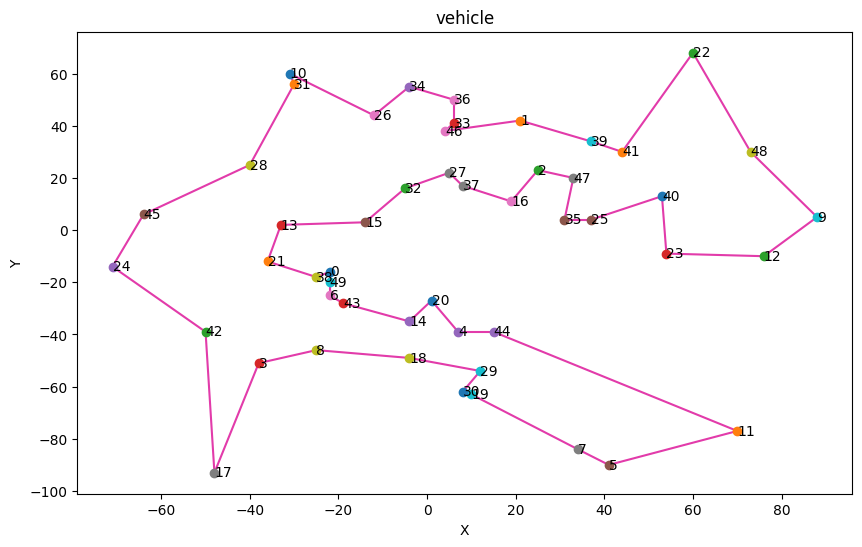

In [172]:
plt.figure(figsize=(10,6))
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        a=int(a)
        b=int(b)
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.title('%d '%K + 'vehicles' if K > 1 else 'vehicle')
plt.xlabel('X')
plt.ylabel('Y')
# plt.gca().axis('off')
plt.show()

In [170]:
print('Longest time spent:', totalTime, '(min)')
print('Total distance:', value(prob.objective), '(km)')

Longest time spent: 1102.8359511736512 (min)
Total distance: 919.0299593113762 (km)
